In [2]:
%load_ext autoreload
%autoreload 2

#  https://mapreader.readthedocs.io/en/latest/Install.html
import os, sys
sys.path.append('../scripts/')
import mapreader
from mapreader import PatchDataset
import cartopy
from torchvision import models
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load .tif

In [2]:
# load map tif paths
from mapreader import loader
my_files = loader("../content/tifs/masked/*.tif")
my_files.add_geo_info() # if pre georeferenced may need to set: target_crs 
print(my_files)

  0%|          | 0/3 [00:00<?, ?it/s]

#images: 3

#parents: 3
SK1070_combined.tif
SK1468_combined.tif
SK1469_combined.tif

#patches: 0



In [3]:
my_files.parents["SK1070_combined.tif"]["shape"]

(1492, 1491, 3)

In [8]:
# not needed now 3 bands
#parent_list = my_files.list_parents()
#for parent in parent_list:
#    my_files.parents[parent]["shape"] = (*my_files.parents[parent]["shape"], 1)

### Patchify

In [56]:
# set directory & patch size (pixels unless -- method="meters" )
my_files.patchify_all(path_save="../content/tifs/patches/", patch_size=25)
my_files.save_patches_as_geotiffs(crs='EPSG:27700')

[INFO] Saving patches in directory named "../content/tifs/patches/".


  0%|          | 0/3 [00:00<?, ?it/s]

..\content\tifs\masked\SK1070_combined.tif
..\content\tifs\masked\SK1468_combined.tif
..\content\tifs\masked\SK1469_combined.tif


  0%|          | 0/10800 [00:00<?, ?it/s]

In [9]:
parent_list = my_files.list_parents()
patch_list = my_files.list_patches()

print(parent_list)
print(patch_list[0:5])  # too many to print them all!

['SK1070_combined.tif', 'SK1468_combined.tif', 'SK1469_combined.tif']
['patch-0-0-25-25-#SK1070_combined.tif#.png', 'patch-0-25-25-50-#SK1070_combined.tif#.png', 'patch-0-50-25-75-#SK1070_combined.tif#.png', 'patch-0-75-25-100-#SK1070_combined.tif#.png', 'patch-0-100-25-125-#SK1070_combined.tif#.png']


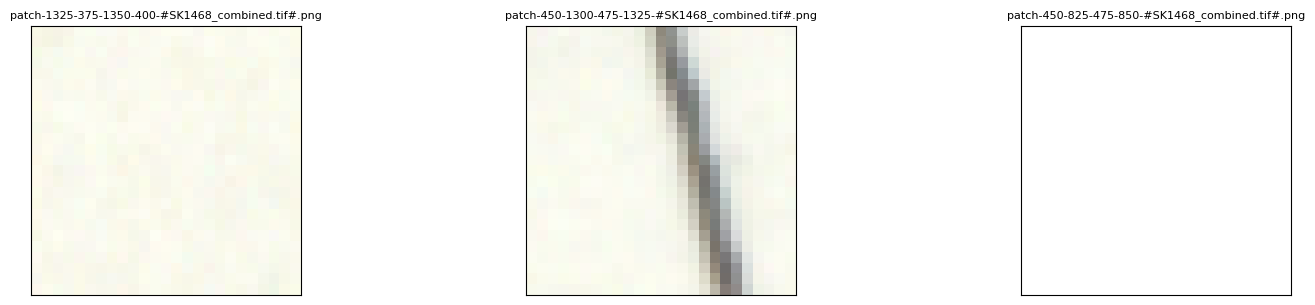

In [10]:
my_files.show_sample(num_samples=3, tree_level="patch")

  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 1 Axes>]

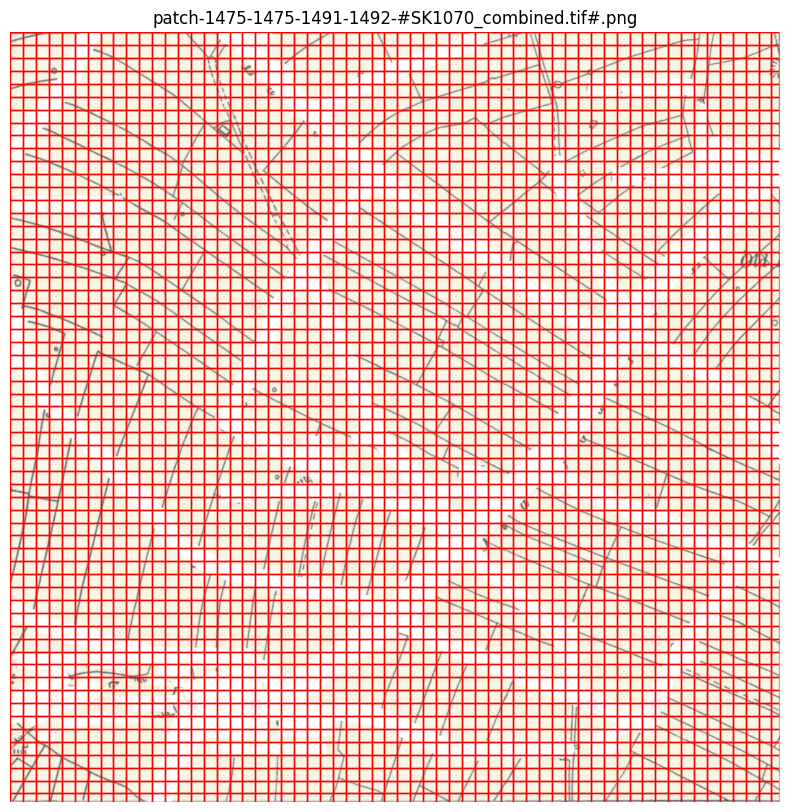

In [11]:
# show patches
parent_list = my_files.list_parents()
my_files.show_parent(parent_list[0])

In [12]:
my_files.calc_pixel_stats()
parent_df, patch_df = my_files.convert_images()
parent_df["url"]="fake_url"

  0%|          | 0/3 [00:00<?, ?it/s]

### Annotate

In [14]:
from mapreader import Annotator

annotator = Annotator(
    patch_df=patch_df,
    parent_df=parent_df,
    task_name="walls",
    labels=["no_wall", "wall"],
    annotations_dir = "../content/annotations_1950/",
    username="DavidA",
    show_context=True,
)

annotator.annotate(resize_to=300, show_context=True, surrounding=3) #to resize up the tiny patch, you might also want show_context=False as its confusing

[INFO] Loading existing annotations for DavidA.
object


Output(layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [ ]:
# load annotations file


In [15]:
# save annotations
annotator.annotations_file

'../content/annotations_1950/walls_#DavidA#-2c94c781a11c0ef2e67ed7e2fba3ad39.csv'

### Perpare train

In [16]:
# Load and check annotations 

import pandas as pd

df = pd.read_csv(annotator.annotations_file, index_col=0)
df["image_id"]=df.index

from mapreader import AnnotationsLoader

annotated_images = AnnotationsLoader()
annotated_images.load(annotations=df)

[INFO] Number of annotations:   330

[INFO] Number of instances of each label (from column "label"):
    - no_wall:  209
    - wall:  121



In [17]:
# view the data
annotated_images.annotations

,image_path,label,image_id,label_index
image_id,,,,
patch-0-0-25-25-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-0-25-25-#SK1070_combined.tif#.png,0
patch-0-100-25-125-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-100-25-125-#SK1070_combined.tif#.png,0
patch-0-1000-25-1025-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-1000-25-1025-#SK1070_combined.tif#.png,0
patch-0-1025-25-1050-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-1025-25-1050-#SK1070_combined.tif#.png,0
patch-0-1050-25-1075-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-1050-25-1075-#SK1070_combined.tif#.png,0
...,...,...,...,...
patch-75-875-100-900-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-75-875-100-900-#SK1070_combined.tif#.png,0
patch-75-900-100-925-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-75-900-100-925-#SK1070_combined.tif#.png,0
patch-75-925-100-950-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-75-925-100-950-#SK1070_combined.tif#.png,0


In [18]:
# label map
annotated_images.labels_map

{0: 'wall', 1: 'no_wall'}

In [19]:
# Prepare datasets and dataloaders
dataloaders = annotated_images.create_dataloaders()

[INFO] Creating datasets using default train/val/test split of 0.7:0.15:0.15 and default transformations.
[INFO] Number of annotations in each set:
    - train:   231
    - val:   49
    - test:   50
[INFO] Using default sampler.


### Train

In [27]:
from mapreader import ClassifierContainer
my_classifier = ClassifierContainer("resnet18", annotated_images.labels_map, dataloaders)

[INFO] Device is set to cpu
[INFO] Initializing model.
[INFO] Loaded "train" with 231 items.
[INFO] Loaded "val" with 49 items.
[INFO] Loaded "test" with 50 items.


In [28]:
# loss function
my_classifier.add_criterion("cross-entropy")

[INFO] Using "CrossEntropyLoss()" as criterion.


In [29]:
# optimizer 
my_classifier.initialize_optimizer()

In [30]:
# scheduler
my_classifier.initialize_scheduler()

In [32]:
# train with default 25 epochs
my_classifier.train()

[INFO] Each step will pass: ['train', 'val'].
2024-02-02 13:42:04 PC05258 [INFO] train    -- 1/25 --     16/231 (  6.9% ) -- Loss: 0.697
2024-02-02 13:42:07 PC05258 [INFO] train    -- 1/25 --     96/231 ( 41.6% ) -- Loss: 0.092
2024-02-02 13:42:10 PC05258 [INFO] train    -- 1/25 --    176/231 ( 76.2% ) -- Loss: 0.395
2024-02-02 13:42:12 PC05258 [INFO] train    -- 1/25 -- Loss: 0.493; F_macro: 76.89; R_macro: 76.04
2024-02-02 13:42:12 PC05258 [INFO] val      -- 1/25 --      16/49 ( 32.7% ) -- Loss: 0.193
2024-02-02 13:42:13 PC05258 [INFO] val      -- 1/25 -- Loss: 0.138; F_macro: 93.15; R_macro: 91.67

2024-02-02 13:42:13 PC05258 [INFO] train    -- 2/25 --     16/231 (  6.9% ) -- Loss: 0.077
2024-02-02 13:42:16 PC05258 [INFO] train    -- 2/25 --     96/231 ( 41.6% ) -- Loss: 0.041
2024-02-02 13:42:19 PC05258 [INFO] train    -- 2/25 --    176/231 ( 76.2% ) -- Loss: 0.878
2024-02-02 13:42:22 PC05258 [INFO] train    -- 2/25 -- Loss: 0.319; F_macro: 86.45; R_macro: 85.61
2024-02-02 13:42:22

### Plot metrics

In [33]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

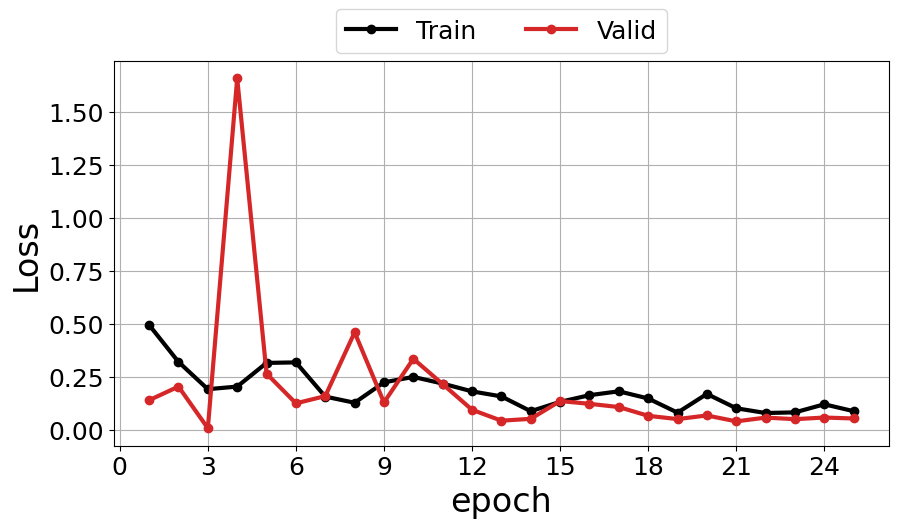

In [34]:
# loss per epoch of training and validation
my_classifier.plot_metric(
    y_axis=["epoch_loss_train", "epoch_loss_val"],
    y_label="Loss",
    legends=["Train", "Valid"],
)

### Testing

In [22]:
my_classifier.inference(set_name="test")

[INFO] Each step will pass: ['test'].
2024-01-09 14:18:49 PC05258 [INFO] test     -- 26/26 --      16/50 ( 32.0% ) -- 
[INFO] Total time: 0m 1s


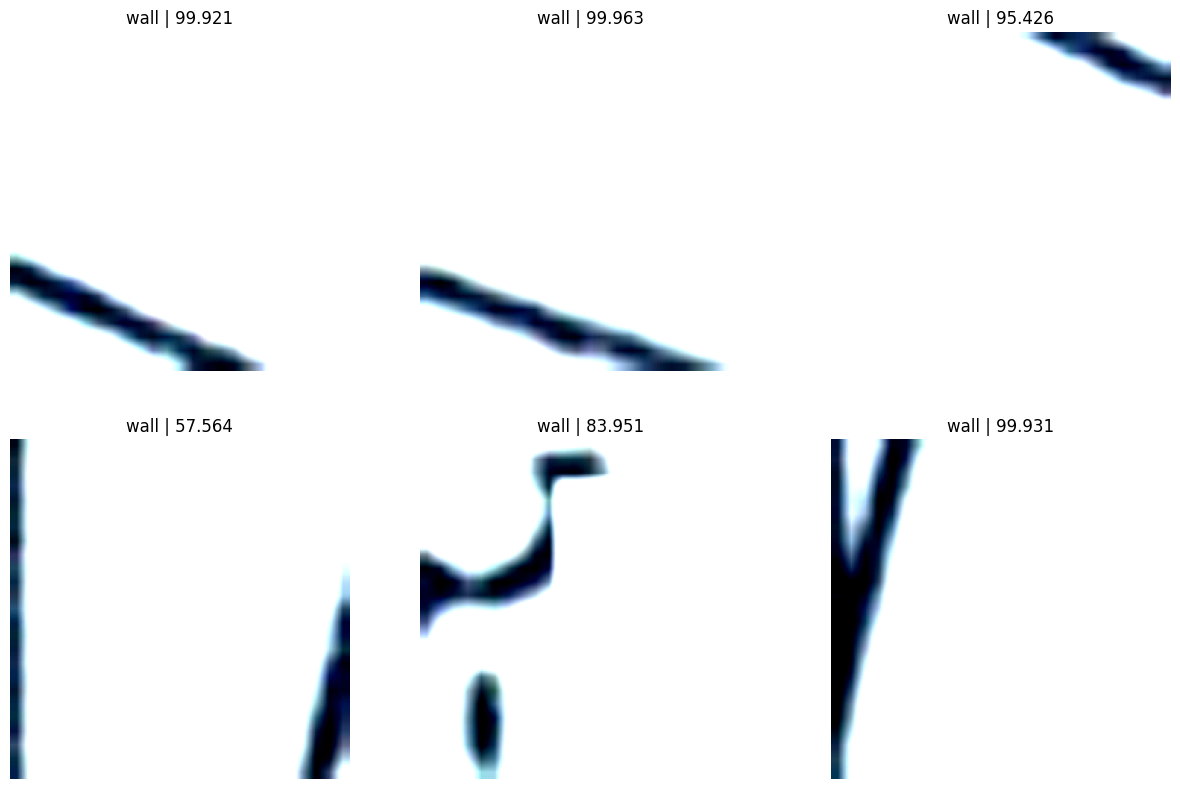

In [23]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall")

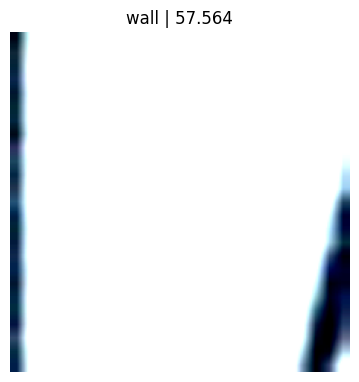

In [24]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall", max_conf=80)

In [35]:
my_classifier.calculate_add_metrics(
    y_true=my_classifier.orig_label,
    y_pred=my_classifier.pred_label,
    y_score=my_classifier.pred_conf,
    phase="test",
)

In [36]:
my_classifier.metrics["epoch_rocauc_macro_test"]

[2.885244448993527]

### Save

In [38]:
my_classifier.save("../notebooks/models/test_3.pkl")

### Model Inference

In [39]:
infer = PatchDataset("../content/annotations_1950/walls_#DavidA#-2c94c781a11c0ef2e67ed7e2fba3ad39.csv", delimiter=",", transform="test")

[INFO] Reading "../content/annotations_1950/walls_#DavidA#-2c94c781a11c0ef2e67ed7e2fba3ad39.csv".


In [40]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(infer, set_name="infer")

In [41]:
my_classifier.inference(set_name="infer")

[INFO] Each step will pass: ['infer'].
2024-02-02 13:54:25 PC05258 [INFO] infer    -- 26/26 --     16/330 (  4.8% ) -- 
2024-02-02 13:54:26 PC05258 [INFO] infer    -- 26/26 --     96/330 ( 29.1% ) -- 
2024-02-02 13:54:27 PC05258 [INFO] infer    -- 26/26 --    176/330 ( 53.3% ) -- 
2024-02-02 13:54:28 PC05258 [INFO] infer    -- 26/26 --    256/330 ( 77.6% ) -- 
2024-02-02 13:54:29 PC05258 [INFO] infer    -- 26/26 --    330/330 (100.0% ) -- 
[INFO] Total time: 0m 5s


### Add predictions to metadata and save

In [152]:
import numpy as np

infer.patch_df['predicted_label'] = my_classifier.pred_label
infer.patch_df['pred'] = my_classifier.pred_label_indices
infer.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [73]:
infer.patch_df

,image_id,image_path,label
0,patch-0-0-25-25-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
1,patch-0-100-25-125-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
2,patch-0-1000-25-1025-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
3,patch-0-1025-25-1050-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
4,patch-0-1050-25-1075-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
...,...,...,...
995,patch-75-875-100-900-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
996,patch-75-900-100-925-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
997,patch-75-925-100-950-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
998,patch-75-950-100-975-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall


0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

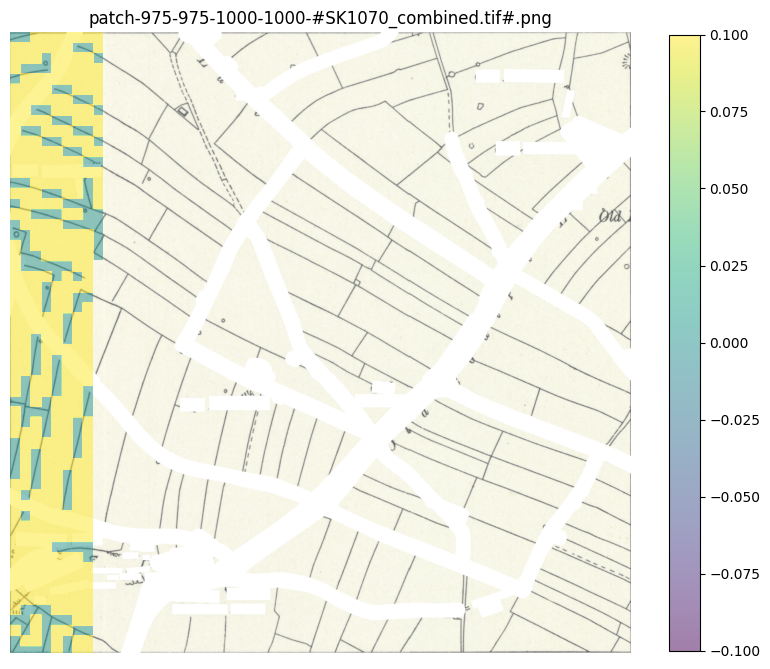

In [153]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

infer_df = infer.patch_df
my_maps.add_metadata(infer_df, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[0], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

### Full data test

In [20]:
patch_df.reset_index(inplace=True, drop=False)

In [21]:
patch_df.head()

,image_id,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,geotiff_path,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B
0,patch-0-0-25-25-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 0, 25, 25)","(-1.8516676236042906, 53.23577337869845, -1.85...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2357733786984...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.832157,0.830482,0.789289,0.176909,0.173345,0.161569
1,patch-0-25-25-50-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 25, 25, 50)","(-1.8516676236042906, 53.2356229416401, -1.851...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2356229416401...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.961293,0.953682,0.895755,0.039232,0.041379,0.037379
2,patch-0-50-25-75-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 50, 25, 75)","(-1.8516676236042906, 53.23547250458175, -1.85...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2354725045817...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.961092,0.955765,0.898704,0.040898,0.039841,0.035361
3,patch-0-75-25-100-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 75, 25, 100)","(-1.8516676236042906, 53.2353220675234, -1.851...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2353220675234...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.959128,0.953180,0.895216,0.041304,0.040486,0.035594
4,patch-0-100-25-125-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 100, 25, 125)","(-1.8516676236042906, 53.235171630465054, -1.8...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2351716304650...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.882359,0.880345,0.830720,0.150095,0.147566,0.134672


In [42]:
predictions = PatchDataset(patch_df, transform="test")

In [43]:
predictions

In [44]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(predictions, set_name="predictions")

In [45]:
my_classifier.inference(set_name="predictions")

[INFO] Each step will pass: ['predictions'].
2024-02-02 13:54:52 PC05258 [INFO] predictions -- 26/26 --   16/10800 (  0.1% ) -- 
2024-02-02 13:54:53 PC05258 [INFO] predictions -- 26/26 --   96/10800 (  0.9% ) -- 
2024-02-02 13:54:54 PC05258 [INFO] predictions -- 26/26 --  176/10800 (  1.6% ) -- 
2024-02-02 13:54:55 PC05258 [INFO] predictions -- 26/26 --  256/10800 (  2.4% ) -- 
2024-02-02 13:54:56 PC05258 [INFO] predictions -- 26/26 --  336/10800 (  3.1% ) -- 
2024-02-02 13:54:57 PC05258 [INFO] predictions -- 26/26 --  416/10800 (  3.9% ) -- 
2024-02-02 13:54:58 PC05258 [INFO] predictions -- 26/26 --  496/10800 (  4.6% ) -- 
2024-02-02 13:54:59 PC05258 [INFO] predictions -- 26/26 --  576/10800 (  5.3% ) -- 
2024-02-02 13:55:00 PC05258 [INFO] predictions -- 26/26 --  656/10800 (  6.1% ) -- 
2024-02-02 13:55:01 PC05258 [INFO] predictions -- 26/26 --  736/10800 (  6.8% ) -- 
2024-02-02 13:55:02 PC05258 [INFO] predictions -- 26/26 --  816/10800 (  7.6% ) -- 
2024-02-02 13:55:03 PC05258 [IN

In [46]:
import numpy as np

predictions.patch_df['predicted_label'] = my_classifier.pred_label
predictions.patch_df['pred'] = my_classifier.pred_label_indices
predictions.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

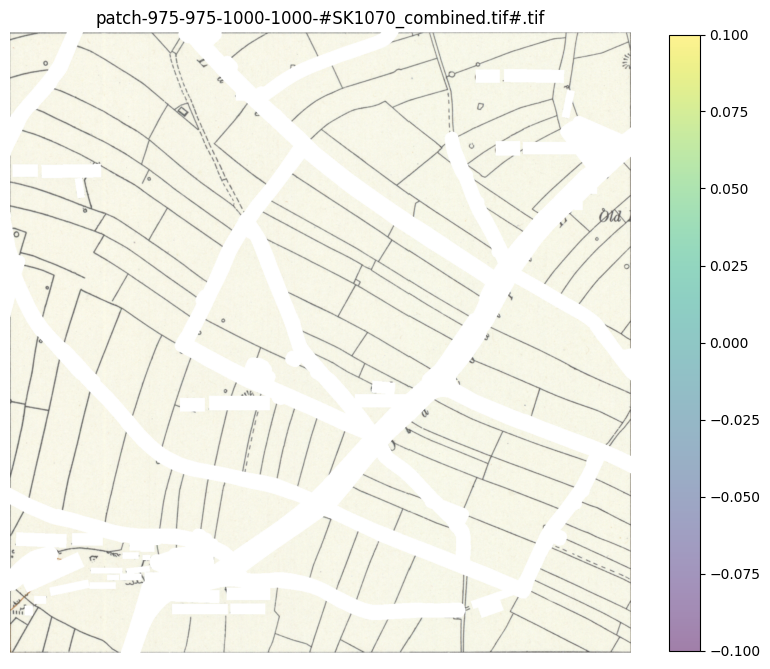

In [47]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*tif", parent_paths="../content/tifs/masked/*.tif")

patch_df_predictions = predictions.patch_df
my_maps.add_metadata(patch_df_predictions, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[0], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

In [50]:
patch_df.tail(2)

,image_id,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,geotiff_path,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B,predicted_label,pred,conf
10798,patch-1475-1450-1492-1475-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 17, 3)","(1475, 1450, 1492, 1475)","(-1.7769374883964921, 53.21797246567226, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21797246567226...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.964734,0.964660,0.916632,0.041197,0.039213,0.041889,no_wall,1,0.992278
10799,patch-1475-1475-1492-1492-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(17, 17, 3)","(1475, 1475, 1492, 1492)","(-1.7769374883964921, 53.21787027512231, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21787027512231...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.946699,0.948938,0.903196,0.073276,0.071365,0.072475,wall,0,1.000000


In [58]:
patch_df_predictions.tail(2)

,image_id,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,geotiff_path,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B,predicted_label,pred,conf
10798,patch-1475-1450-1492-1475-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 17, 3)","(1475, 1450, 1492, 1475)","(-1.7769374883964921, 53.21797246567226, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21797246567226...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.964734,0.964660,0.916632,0.041197,0.039213,0.041889,no_wall,1,0.992278
10799,patch-1475-1475-1492-1492-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(17, 17, 3)","(1475, 1475, 1492, 1492)","(-1.7769374883964921, 53.21787027512231, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21787027512231...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.946699,0.948938,0.903196,0.073276,0.071365,0.072475,wall,0,1.000000


In [60]:
import geopandas as gpd

# change tuple columns to strings
for col in patch_df_predictions.columns:
    if isinstance(patch_df_predictions[col][0], tuple):
        patch_df_predictions[col] = patch_df_predictions[col].apply(str)

geo_patch_df = gpd.GeoDataFrame(patch_df_predictions, geometry="polygon", crs='EPSG:4326')
geo_patch_df.to_file("../content/predictions/patches.geojson", driver="GeoJSON")

In [47]:
patch_df_predictions.to_csv("../content/predictions/predictions_patch_df.csv", sep=",")